In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import namedtuple
from torch.nn.utils import prune

%matplotlib inline

from argparse import ArgumentParser
DATA_DIR = os.path.join(os.getenv('TEACHER_DIR'), 'JHS_data')

In [2]:
# def preprocess(img):
#     transform = transforms.Compose([
#         transforms.Resize((256,256)),
#         transforms.ToTensor(),
#         transforms.Normalize((0.2870, 0.3252, 0.2840), (0.1711, 0.1759, 0.1731))
#     ])
#     img = transform(img).unsqueeze(0)

#     return img


# def postprocess(prediction, shape):
#     softmax = torch.nn.Softmax(dim=1)
#     prediction_soft = softmax(prediction)
#     prediction_max = torch.argmax(prediction_soft, axis=1)
#     transform = transforms.Resize(shape)
#     prediction = transform(prediction_max)

#     prediction_numpy = prediction.cpu().detach().numpy()
#     prediction_numpy = prediction_numpy.squeeze()

#     return prediction_numpy

def preprocess(img):
    """preproces image:
    input is a PIL image.
    Output image should be pytorch tensor that is compatible with your model"""

    img = transforms.functional.resize(img, size=(256, 512), interpolation=transforms.InterpolationMode.LANCZOS)
    trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.2870, 0.3252, 0.2840), (0.1711, 0.1759, 0.1731))])
    img = trans(img)
    img = img.unsqueeze(0)

    return img

def preprocess_small(img):
    """preproces image:
    input is a PIL image.
    Output image should be pytorch tensor that is compatible with your model"""

    img = transforms.functional.resize(img, size=(64, 128), interpolation=transforms.InterpolationMode.LANCZOS)
    trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.2870, 0.3252, 0.2840), (0.1711, 0.1759, 0.1731))])
    img = trans(img)
    img = img.unsqueeze(0)

    return img

def postprocess(prediction, shape):
    """Post process prediction to mask:
    Input is the prediction tensor provided by your model, the original image size.
    Output should be numpy array with size [x,y,n], where x,y are the original size of the image and n is the class label per pixel.
    We expect n to return the training id as class labels. training id 255 will be ignored during evaluation."""
    m = torch.nn.Softmax(dim=1)
    prediction_soft = m(prediction)
    prediction_max = torch.argmax(prediction_soft, axis=1)
    prediction = transforms.functional.resize(prediction_max, size=shape, interpolation=transforms.InterpolationMode.NEAREST)
#     prediction = map_id_to_train_id(prediction)

    prediction_numpy = prediction.cpu().detach().numpy()
    prediction_numpy = prediction_numpy.squeeze()

    return prediction_numpy

In [3]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder_1 = encoder(3, 32)
        self.encoder_2 = encoder(32, 40)
        self.encoder_3 = encoder(40, 50)

        self.middle = convolution_block(50, 63)
        
        self.decoder_1 = decoder(63, 50)
        self.decoder_2 = decoder(50, 40)
        self.decoder_3 = decoder(40, 32)

        self.classifier = nn.Conv2d(32, 19, kernel_size=1, padding=0)

    def forward(self, inputs):
        skip_1, x1 = self.encoder_1(inputs)
        skip_2, x2 = self.encoder_2(x1)
        skip_3, x3 = self.encoder_3(x2)

        x4 = self.middle(x3)

        x5 = self.decoder_1(x4, skip_3)
        x6 = self.decoder_2(x5, skip_2)
        x7 = self.decoder_3(x6, skip_1)

        out = self.classifier(x7)

        return out


class convolution_block(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()

        self.conv_1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)

        self.conv_2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
        self.batchnorm_2 = nn.BatchNorm2d(output_channels)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout2d(p=0.1)

    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = self.dropout(x)

        x = self.conv_2(x)
        x = self.dropout(x)
        x = self.batchnorm_2(x)
        x = self.relu(x)

        return x

class encoder(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()

        self.conv = convolution_block(input_channels, output_channels)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        skip = self.conv(inputs)
        x = self.pool(skip)

        return skip, x

class decoder(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()

        self.up_pool = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2, padding=0)
        self.conv = convolution_block(2*output_channels, output_channels)

    def forward(self, inputs, skip):
        x = self.up_pool(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x
    
import torch
import torch.nn as nn

class Model2(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder_1 = encoder2(3, 32)
        self.encoder_2 = encoder2(32, 48)
        self.encoder_3 = encoder2(48, 72)

        self.middle = convolution_block2(72, 108)
        
        self.decoder_1 = decoder2(108, 72)
        self.decoder_2 = decoder2(72, 48)
        self.decoder_3 = decoder2(48, 32)

        self.classifier = nn.Conv2d(32, 19, kernel_size=1, padding=0)

    def forward(self, inputs):
        skip_1, x1 = self.encoder_1(inputs)
        skip_2, x2 = self.encoder_2(x1)
        skip_3, x3 = self.encoder_3(x2)

        x4 = self.middle(x3)

        x5 = self.decoder_1(x4, skip_3)
        x6 = self.decoder_2(x5, skip_2)
        x7 = self.decoder_3(x6, skip_1)

        out = self.classifier(x7)

        return out


class convolution_block2(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()

        self.conv_1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        self.batchnorm_1 = nn.BatchNorm2d(output_channels)

        self.conv_2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
        self.batchnorm_2 = nn.BatchNorm2d(output_channels)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout2d(p=0.1)

    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = self.dropout(x)
        x = self.batchnorm_1(x)
        x = self.relu(x)

        x = self.conv_2(x)
        x = self.dropout(x)
        x = self.batchnorm_2(x)
        x = self.relu(x)

        return x

class encoder2(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()

        self.conv = convolution_block2(input_channels, output_channels)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        skip = self.conv(inputs)
        x = self.pool(skip)

        return skip, x

class decoder2(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()

        self.up_pool = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2, padding=0)
        self.conv = convolution_block2(2*output_channels, output_channels)

    def forward(self, inputs, skip):
        x = self.up_pool(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x
    
import torch
import torch.nn as nn

class Model3(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder_1 = encoder3(3, 32)
        self.encoder_2 = encoder3(32, 48)
        self.encoder_3 = encoder3(48, 72)
        self.encoder_4 = encoder3(72, 108)

        self.middle = convolution_block3(108, 162)
        
        self.decoder_1 = decoder3(162, 108)
        self.decoder_2 = decoder3(108, 72)
        self.decoder_3 = decoder3(72, 48)
        self.decoder_4 = decoder3(48, 32)

        self.classifier = nn.Conv2d(32, 19, kernel_size=1, padding=0)

    def forward(self, inputs):
        skip_1, x1 = self.encoder_1(inputs)
        skip_2, x2 = self.encoder_2(x1)
        skip_3, x3 = self.encoder_3(x2)
        skip_4, x4 = self.encoder_4(x3)

        x5 = self.middle(x4)

        x6 = self.decoder_1(x5, skip_4)
        x7 = self.decoder_2(x6, skip_3)
        x8 = self.decoder_3(x7, skip_2)
        x9 = self.decoder_4(x8, skip_1)

        out = self.classifier(x9)

        return out


class convolution_block3(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()

        self.conv_1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        self.batchnorm_1 = nn.BatchNorm2d(output_channels)

        self.conv_2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
        self.batchnorm_2 = nn.BatchNorm2d(output_channels)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout2d(p=0.2)

    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = self.dropout(x)
        x = self.batchnorm_1(x)
        x = self.relu(x)

        x = self.conv_2(x)
        x = self.dropout(x)
        x = self.batchnorm_2(x)
        x = self.relu(x)

        return x

class encoder3(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()

        self.conv = convolution_block3(input_channels, output_channels)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        skip = self.conv(inputs)
        x = self.pool(skip)

        return skip, x

class decoder3(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()

        self.up_pool = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2, padding=0)
        self.conv = convolution_block3(2*output_channels, output_channels)

    def forward(self, inputs, skip):
        x = self.up_pool(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x

In [7]:
model3 = Model()
model3.load_state_dict(torch.load("scarlet-sea-4.pth", map_location=torch.device('cpu')))
print(sum(p.numel() for p in model3.parameters()))

model2 = Model2()
model2.load_state_dict(torch.load("breezy-shadow-2.pth", map_location=torch.device('cpu')))
print(sum(p.numel() for p in model2.parameters()))

model1 = Model3()
model1.load_state_dict(torch.load("etheral-pond-18.pth", map_location=torch.device('cpu')))
print(sum(p.numel() for p in model1.parameters() if p.requires_grad))

model4 = Model()
model4.load_state_dict(torch.load("dazzling-smoke-17.pth", map_location=torch.device('cpu')))

306616
581507
1361807


<All keys matched successfully>

In [27]:
transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.2870, 0.3252, 0.2840), (0.1711, 0.1759, 0.1731))
])
def preprocess_masks(masks):
    transform = transforms.Compose([
        transforms.Resize((256, 256),transforms.InterpolationMode.NEAREST),
        transforms.ToTensor(),
    ])
    masks = transform(masks)
    masks = (masks*255).long().squeeze()
    masks = map_id_to_train_id(masks)

    return masks

def preprocess_masks_small(masks):
    transform = transforms.Compose([
        transforms.Resize((128, ),transforms.InterpolationMode.NEAREST),
        transforms.ToTensor(),
    ])
    masks = transform(masks)
    masks = (masks*255).long().squeeze()
    masks = map_id_to_train_id(masks)

    return masks

def preprocess_masks2(masks):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    masks = transform(masks)
    masks = (masks*255).long().squeeze()
    masks = map_id_to_train_id(masks)

    return masks

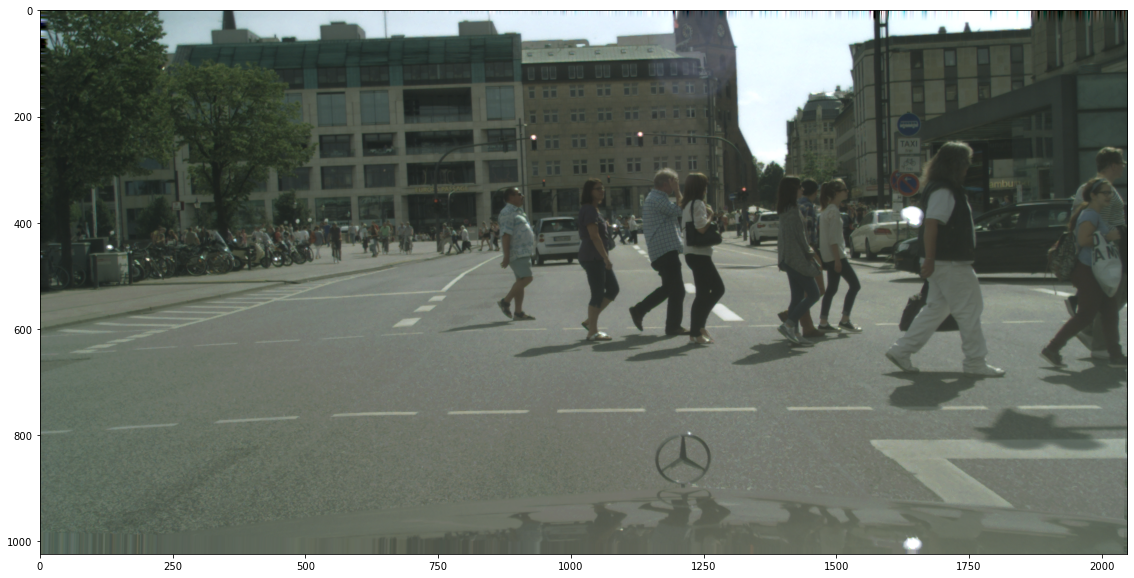

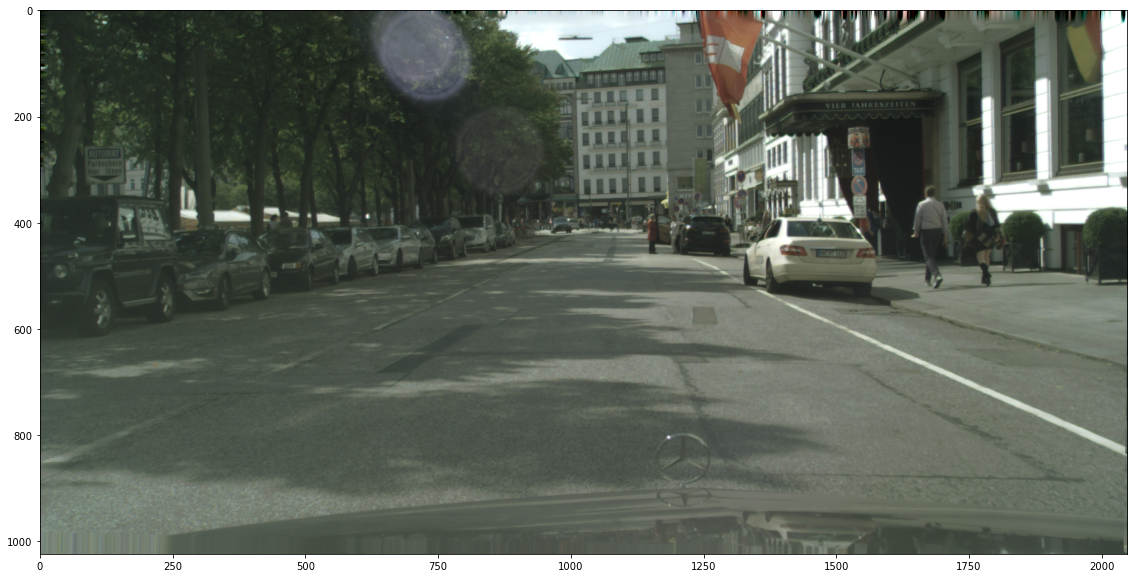

In [45]:
val = datasets.Cityscapes("/gpfs/work5/0/jhstue005/JHS_data/CityScapes", split='train', mode='fine', target_type='semantic', transform=preprocess, target_transform=preprocess_masks)
validationloader = DataLoader(val, batch_size=2, shuffle=True, num_workers=1, pin_memory=True)
val2 = datasets.Cityscapes("/gpfs/work5/0/jhstue005/JHS_data/CityScapes", split='train', mode='fine', target_type='semantic', target_transform=preprocess_masks2)
validationloader2 = DataLoader(val2, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)
validationloader3 = [val2[7],val2[9]]
for (lol,lmao) in validationloader3:
    plt.figure(figsize=(20, 10))
    plt.imshow(lol)
    

In [29]:
colors = {
    0: (128, 64,128) ,
    1: (244, 35,232) ,
    2: ( 70, 70, 70) ,
    3: (102,102,156) ,
    4: (190,153,153) ,
    5: (153,153,153) ,
    6: (250,170, 30) ,
    7: (220,220,  0) ,
    8: (107,142, 35) ,
    9: (152,251,152) ,
    10: ( 70,130,180) ,
    11: (220, 20, 60) ,
    12: (255,  0,  0) ,
    13: (  0,  0,142) ,
    14: (  0,  0, 70) ,
    15: (  0, 60,100) ,
    16: (  0, 80,100) ,
    17: (  0,  0,230) ,
    18: (119, 11, 32) ,
    -1: (  0,  0,142) 
}

def mask_to_rgb(mask, class_to_color):
    # Get dimensions of the input mask
    height, width = mask.shape

    # Initialize an empty RGB mask
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Iterate over each class and assign corresponding RGB color
    for class_idx, color in class_to_color.items():
        # Mask pixels belonging to the current class
        class_pixels = mask == class_idx
        # Assign RGB color to the corresponding pixels
        rgb_mask[class_pixels] = color

    return rgb_mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.617174106677617


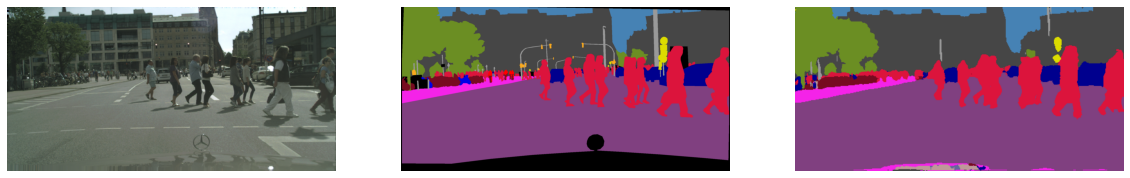

0.617174106677617


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.5660540602149701


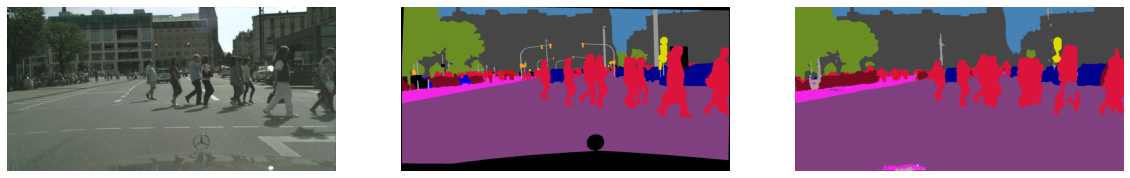

0.5660540602149701


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.5601042961202767


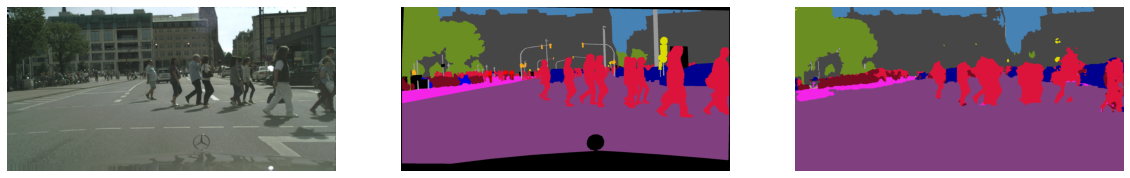

0.5601042961202767


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.5092036568928286


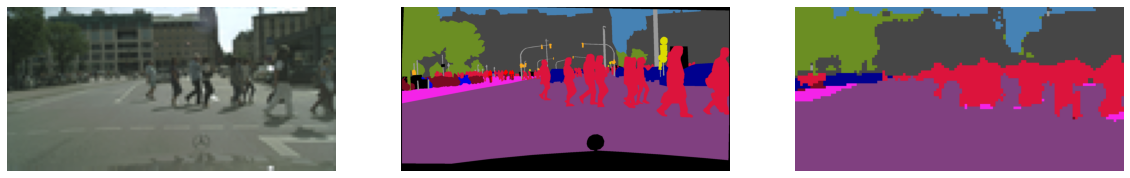

0.5092036568928286


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.6113837131627097


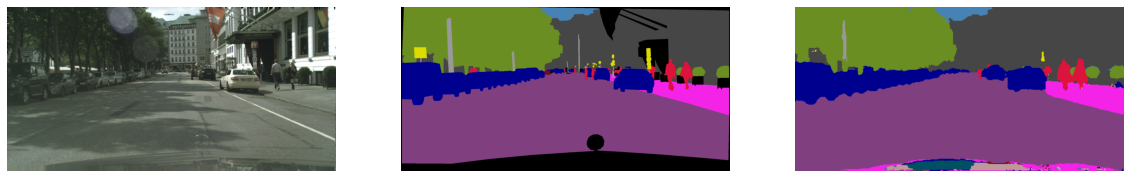

0.6113837131627097


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.6807137667386461


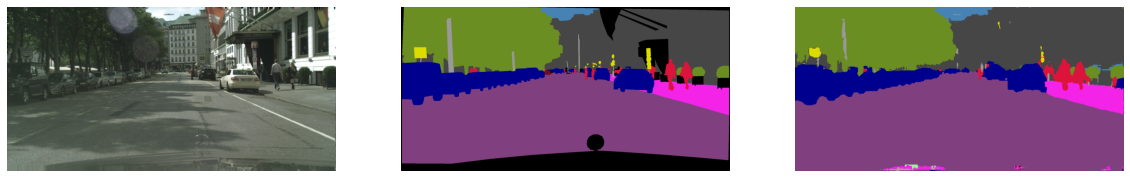

0.6807137667386461


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.677830689314674


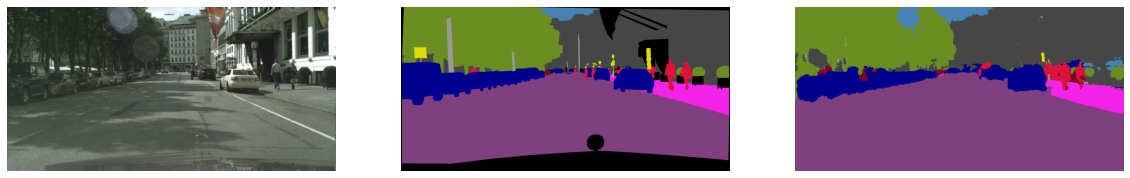

0.677830689314674


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.7575035107992593


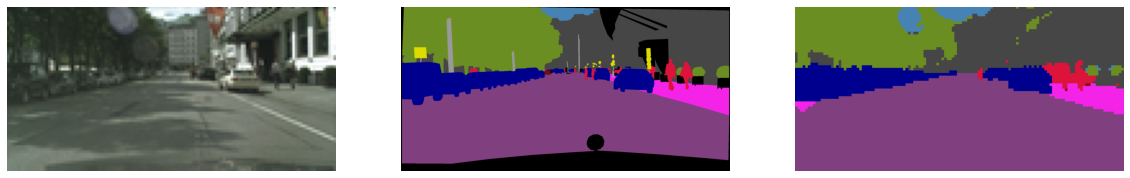

0.7575035107992593


In [46]:
def renormalize_image(image):
    """
    Renormalizes the image to its original range.
    
    Args:
        image (numpy.ndarray): Image tensor to renormalize.
    
    Returns:
        numpy.ndarray: Renormalized image tensor.
    """
    mean = [0.2870, 0.3252, 0.2840]
    std = [0.1711, 0.1759, 0.1731]  
    renormalized_image = image * std + mean
    return renormalized_image

def DICE(images,masks,model):
    dice_tot = []
    for j in range(images.shape[0]):
        image_real = renormalize_image(images[j].numpy().squeeze().transpose(1, 2, 0))
        image = model(images[j])
        pred = postprocess(image, (1024,2048))
        pred_mask_rgb = mask_to_rgb(pred, colors)
        pred = pred.flatten()

        mask_rgb = mask_to_rgb(masks.squeeze(), colors)
        mask = masks.squeeze().flatten()

        dice = []

        for l in range(19):
            pred_tot = len(pred[pred==l])
            mask_tot = len(mask[mask==l])
            inter = len([i for i, v in enumerate(pred) if v == l and v == mask[i]])
            score = (2.*inter + 0.00001)/(pred_tot + mask_tot + 0.00001)
            dice.append(score)

        mean_score = np.sum(dice)/19
        dice_tot.append(mean_score)
        print(mean_score)

        plt.figure(figsize=(20, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(image_real)
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask_rgb)
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask_rgb)
        plt.axis('off')

        plt.show()
    print(np.sum(dice_tot)/images.shape[0])

model1.eval()
model2.eval()
model3.eval()
model4.eval()
with torch.no_grad():
    for i, (images, masks) in enumerate(validationloader3):
        if i >= 3:
            break
        masks = masks.numpy()
        images_large = preprocess(images).unsqueeze(0)
        images_small = preprocess_small(images).unsqueeze(0)
        DICE(images_large,masks,model1)
        DICE(images_large,masks,model2)
        DICE(images_large,masks,model3)
        DICE(images_small,masks,model4)

In [ ]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    return mean, std


# mean, std = get_mean_std(validationloader)
# print(mean, std)

In [ ]:
# visualize examples (No modifications needed)
colors = {
    0: (128, 64,128) ,
    1: (244, 35,232) ,
    2: ( 70, 70, 70) ,
    3: (102,102,156) ,
    4: (190,153,153) ,
    5: (153,153,153) ,
    6: (250,170, 30) ,
    7: (220,220,  0) ,
    8: (107,142, 35) ,
    9: (152,251,152) ,
    10: ( 70,130,180) ,
    11: (220, 20, 60) ,
    12: (255,  0,  0) ,
    13: (  0,  0,142) ,
    14: (  0,  0, 70) ,
    15: (  0, 60,100) ,
    16: (  0, 80,100) ,
    17: (  0,  0,230) ,
    18: (119, 11, 32) ,

}

# class_names = [
#     'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
#     'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
#     'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
# ]

def mask_to_rgb(mask, class_to_color):
    """
    Converts a numpy mask with multiple classes indicated by integers to a color RGB mask.

    Parameters:
        mask (numpy.ndarray): The input mask where each integer represents a class.
        class_to_color (dict): A dictionary mapping class integers to RGB color tuples.

    Returns:
        numpy.ndarray: RGB mask where each pixel is represented as an RGB tuple.
    """
    # Get dimensions of the input mask
    height, width = mask.shape

    # Initialize an empty RGB mask
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Iterate over each class and assign corresponding RGB color
    for class_idx, color in class_to_color.items():
        # Mask pixels belonging to the current class
        class_pixels = mask == class_idx
        # Assign RGB color to the corresponding pixels
        rgb_mask[class_pixels] = color

    return rgb_mask

def visualize_segmentation(model, dataloader, num_examples=5):
    """
    Visualizes segmentation results from a given model using a dataloader.

    Args:
        model (torch.nn.Module): The segmentation model to visualize.
        dataloader (torch.utils.data.DataLoader): Dataloader providing image-mask pairs.
        num_examples (int, optional): Number of examples to visualize. Defaults to 5.

    Returns:
        None
    """
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i >= num_examples:
                break

            masks = masks.numpy()*255

            for j in range(images.shape[0]):
                output = model(images[j])
                predict = postprocess(output, (1024, 2048))
                
                images_np = images[j].numpy().squeeze()
                print(images_np.shape)
                image = renormalize_image(images_np.transpose(1, 2, 0))

                mask = masks[j].squeeze()
                pred_mask = predict
                                
                # Convert mask and predicted mask to RGB for visualization
                mask_rgb = mask_to_rgb(mask, colors)
                pred_mask_rgb = mask_to_rgb(pred_mask, colors)
                
                # Get unique classes present in the ground truth and predicted masks
                unique_classes_gt = np.unique(mask)
                unique_classes_pred = np.unique(pred_mask)
                
                unique_classes_gt = np.delete(unique_classes_gt, [0, -1])
                unique_classes_pred= np.delete(unique_classes_pred, 0)
                
                unique_classes_gt[unique_classes_gt == 255] = 0
                unique_classes_pred[unique_classes_pred == 255] = 0
                
                
                # Map class indices to class names from the VOC2012 dataset
#                 classes_gt = [class_names[int(idx)] for idx in unique_classes_gt]
#                 classes_pred = [class_names[int(idx)] for idx in unique_classes_pred]
                
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(image)
                plt.title('Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(mask_rgb)
#                 plt.title(f'Ground Truth Mask Classes:\n {classes_gt}')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(pred_mask_rgb)
#                 plt.title(f'Predicted Mask Predicted Classes:\n {classes_pred}')
                plt.axis('off')

                plt.show()
                

def renormalize_image(image):
    """
    Renormalizes the image to its original range.
    
    Args:
        image (numpy.ndarray): Image tensor to renormalize.
    
    Returns:
        numpy.ndarray: Renormalized image tensor.
    """
    mean = [0.2870, 0.3252, 0.2840]
    std = [0.1711, 0.1759, 0.1731]  
    renormalized_image = image * std + mean
    return renormalized_image

In [ ]:
visualize_segmentation(model, validationloader, num_examples=1)

In [15]:
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

LABELS = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

def map_id_to_train_id(label_id):
    """map the id to the train id for cityscapes masks
    input: Tensor of shape (batch_size, height, width) with values from 0 to 33
    output: Tensor of shape (batch_size, height, width) with values from 0 to 18
    """
    # create a tensor with the same shape as the input tensor and fill it with the value 255
    train_id_tensor = torch.full_like(label_id, 255)
    for label in LABELS:
        # replace the value in the tensor with the train id if the value in the input tensor is equal to the id of the label
        train_id_tensor[label_id == label.id] = label.trainId
    return train_id_tensor
